# Analyze boreal biomass by polygonal zone
* updated to try COGReader and its zonal_statistics
* some test output from first clipping attempts here: /projects/shared-buckets/lduncanson/test_output/analyze_agb

In [3]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 KB 2.5 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import os
import rasterio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import mapping
from rasterstats import zonal_stats
import geopandas as gpd
import pandas as pd
import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Read in vector file of polygon zones and boreal tiles
* get the tiles intersecting zones of interest

AxesSubplot(0.125,0.15901;0.775x0.686981)
CPU times: user 3.33 s, sys: 308 ms, total: 3.64 s
Wall time: 6.6 s


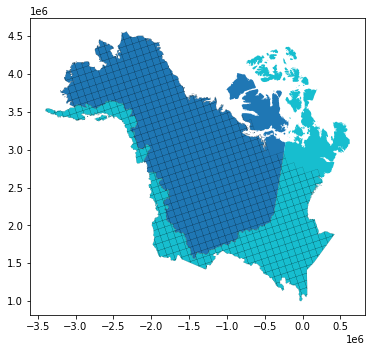

In [39]:
%%time
# Get the shp filename
# shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/arc/bioclimate_dd.shp'
# shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/hydrobasins/hybas_lev03_clip_above.gpkg'
# shp_fn = '/projects/my-public-bucket/misc_files/hybas_lake_ar_lev08_v1c.shp'
# shp_fn = '/projects/my-public-bucket/misc_files/wwf_terr_ecos.shp'
#shp_fn = '/projects/my-public-bucket/LVIS_ABoVE_spatial_footprints_2017_2019.gpkg'

# Reading in zones of interest
above_domain_fn = '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp'
above_domain_gdf = gpd.read_file(above_domain_fn)#.cx[-180:-150, 50:75]
above_domain_gdf['area_sq_km'] = above_domain_gdf.area / 1e6
above_domain_gdf.sort_values(by = 'area_sq_km', ascending=False, inplace=True)
above_crs = above_domain_gdf.crs
ax = above_domain_gdf.plot(column='Region')

# Reading in boreal tiles
boreal_tiles_fn = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
boreal_tiles = gpd.read_file(boreal_tiles_fn).to_crs(above_crs)
boreal_tiles_above = gpd.overlay(boreal_tiles, above_domain_gdf, how='intersection')
ax = boreal_tiles_above.geometry.boundary.plot(color=None, edgecolor='k',linewidth = .1, ax=ax)
print(ax)

## Build a VRT of the boreal biomass COGs
* use tindex master json to create a list for gdal

In [28]:
indir = '/projects/shared-buckets/lduncanson/DPS_tile_lists'
# a writable outdir
outdir = '/projects/my-public-bucket/analyze_agb'

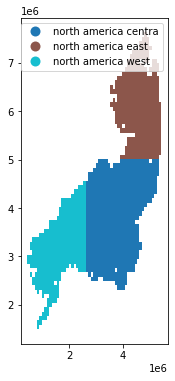

In [45]:
plt.rcParams['figure.figsize'] = [6, 6]
tile_json_fn = os.path.join(indir, "AGB_tindex_master.json")
tiles = gpd.read_file(tile_json_fn)

# North america subset
tiles_na = tiles[tiles['tile_group'].str.contains("america")]

# Write a vrt list and a vrt
vrt_list = os.path.join(outdir,"AGB_tindex_na.txt")

with open(vrt_list, 'w') as f:
    
    for text in tiles_na.s3.tolist():
        f.write(text.replace("s3:/","/vsis3") + '\n')

tiles_na.plot(column='tile_group', legend=True)


#### Build VRT of AGB COGs

In [53]:
vrt_fn = vrt_list.replace('.txt','.vrt')

#get the bbox as part of the gdalbuildvrt and define it, to save time calculating
tiles_na.total_bounds.tolist()
!time gdalbuildvrt -te 458521 1503304 5408522 7623304 -input_file_list $vrt_list $vrt_fn

0...10...20...30...40...50...60...70...80...90...100 - done.

real	3m49.749s
user	0m3.801s
sys	0m0.664s


### Using COGReader to access and analze VRT
* select a test zone
* read the VRT: https://cogeotiff.github.io/rio-tiler/advanced/feature/
* get basic image stats: https://cogeotiff.github.io/rio-tiler/examples/Using-rio-tiler/
* get zonal stats: https://cogeotiff.github.io/rio-tiler/advanced/zonal_stats/

In [ ]:
from rio_tiler.io import COGReader
from rio_tiler.models import ImageData

Select a test zone

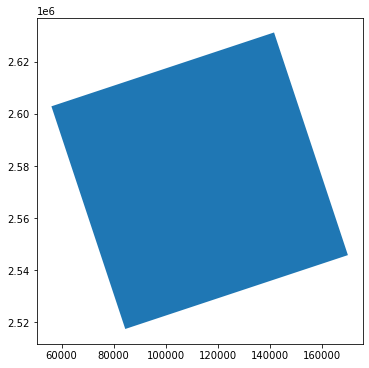

In [66]:
# Get a geojson feature for the zones
#geopandas.GeoSeries([shapely_polygon]).to_json()
#boreal_tiles.to_json()
test_zone = boreal_tiles_above[boreal_tiles_above.tile_num == 1777]
test_zone.plot()

Read COG portion that intersects a feature

In [69]:
with COGReader(vrt_fn) as cog:
    # Read data for a given geojson polygon
    img: ImageData = cog.feature(test_zone.geometry, max_size=1024)  # we limit the max_size to 1024

RioTilerError: Invalid geometry

Test some basic image stats with COGReader

In [70]:
with COGReader(vrt_fn) as cog:
    meta = cog.statistics(max_size=256)

    assert isinstance(meta, dict)
    print(list(meta))
    print(meta["1"].dict())

AttributeError: 'COGReader' object has no attribute 'statistics'

### Enable Zonal Stats with COGReader

In [ ]:
import attr
from typing import Any, Union, Optional, List, Dict

from rio_tiler import io
from rio_tiler.utils import get_array_statistics
from rio_tiler.models import BandStatistics

from geojson_pydantic.features import Feature, FeatureCollection
from geojson_pydantic.geometries import Polygon

class COGReader(io.COGReader):
    """Custom COGReader with zonal_statistics method."""

    def zonal_statistics(
            self,
            geojson: Union[FeatureCollection, Feature],
            categorical: bool = False,
            categories: Optional[List[float]] = None,
            percentiles: List[int] = [2, 98],
            hist_options: Optional[Dict] = None,
            max_size: int = None,
            **kwargs: Any,
        ) -> FeatureCollection:
            """Return statistics from GeoJSON features.

            Args:
                geojson (Feature or FeatureCollection): a GeoJSON Feature or FeatureCollection.
                categorical (bool): treat input data as categorical data. Defaults to False.
                categories (list of numbers, optional): list of categories to return value for.
                percentiles (list of numbers, optional): list of percentile values to calculate. Defaults to `[2, 98]`.
                hist_options (dict, optional): Options to forward to numpy.histogram function.
                max_size (int, optional): Limit the size of the longest dimension of the dataset read, respecting bounds X/Y aspect ratio. Defaults to None.
                kwargs (optional): Options to forward to `self.preview`.

            Returns:
                FeatureCollection

            """
            kwargs = {**self._kwargs, **kwargs}

            hist_options = hist_options or {}

            # We transform the input Feature to a FeatureCollection
            if not isinstance(geojson, FeatureCollection):
                geojson = FeatureCollection(features=[geojson])

            for feature in geojson:
                # Get data overlapping with the feature (using COGReader.feature method)
                data = self.feature(
                    feature.dict(exclude_none=True),
                    max_size=max_size,
                    **kwargs,
                )

                # Get band statistics for the data
                stats = get_array_statistics(
                    data.as_masked(),
                    categorical=categorical,
                    categories=categories,
                    percentiles=percentiles,
                    **hist_options,
                )

                # Update input feature properties and add the statistics
                feature.properties = feature.properties or {}
                feature.properties.update(
                    {
                        "statistics": {
                            f"{data.band_names[ix]}": BandStatistics(
                                **stats[ix]
                            )
                            for ix in range(len(stats))
                        }
                    }
                )

            return geojson


# Test output from first clipping attempts

#### Read VRT of AGB COGs with rasterio

In [44]:

import rasterio.crs

with rasterio.open(vrt_fn, mode='r') as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.indexes)
    to_crs = src.crs

RasterioIOError: /projects/my-public-bucket/analyze_agb/AGB_tindex_na.vrt: No such file or directory

In [134]:
# Reproject the vector to the raster crs
in_gdf = vector_gdf.to_crs(to_crs)
in_gdf.shape

(5, 19)

<AxesSubplot:>

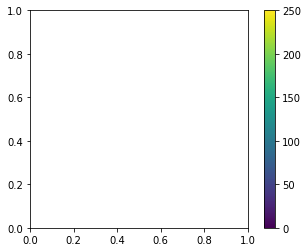

In [135]:
# Attach zonal_stats to output geodataframe
out_gdf = in_gdf.join(
    pd.DataFrame(
        zonal_stats(
            vectors=in_gdf['geometry'], 
            raster=r_fn, 
            stats=['max','mean', 'median','std','min','sum','count']
        )
    ),
    how='left'
)
out_gdf.plot('mean', cmap='viridis', legend=True, vmin=0, vmax=250)

In [141]:
out_gdf.crs


<Projected CRS: PROJCS["unknown",GEOGCS["NAD83",DATUM["North_Ameri ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [68]:
def get_gdf_lists(input_gdf, zone_field_name, SHOW_CLIP=False):
    '''
    From the input gdf get:
        geoms_list: the geoms (features) that you will use to clip
        zone_name_list: the names of the geoms (features)
    '''
    geoms_list = []
    zone_name_list = []

    for idx in input_gdf.index:
        #print(idx)
        geom =  input_gdf.loc[idx].geometry
        zonename =  input_gdf.loc[idx][zone_field_name]
        print(zone_field_name, zonename)
        if geom not in geoms_list:
            if SHOW_CLIP:
                gpd.GeoSeries(geom).plot()
            geoms_list.append(geom)
            zone_name_list.append(zonename)

    print(f'# of indiv features: {len(geoms_list)}')
    return [geoms_list, zone_name_list]

def do_clip(r_fn, input_gdf, zone_field_name, indir, outdir, vector_fn, SHOW_CLIP = True):
    
    geoms_list, zone_name_list = get_gdf_lists(input_gdf, zone_field_name, SHOW_CLIP = False)
    
    feature_pass_list = []
    feature_fail_list = []
    no_raster_intersection_list = []

    with rasterio.open(r_fn, "r") as r:

        for idx, zone_name in enumerate(zone_name_list):
            print(zone_name)
            geom = geoms_list[idx]
            
            feature_gdf = None
            try:
                feature_gdf = gpd.GeoDataFrame({'name':zone_name, 'geometry':geom}, crs=from_epsg(4326)) #index=[0], 
                feature_gdf.plot()
                # Reproject feature_gdf to raster crs
                feature_gdf = feature_gdf.to_crs(r.crs)
            except ValueError:
                print(f"Cant get geodataframe for feature {zone_name}")
                feature_fail_list.append(zone_name)
                
                continue

            zone_name = f'{zone_name:03}'
            out_r_fn = os.path.join(os.path.split(r_fn.replace(indir, outdir))[0] , os.path.split(r_fn)[1].replace(os.path.splitext(r_fn)[1], '_'+vector_fn+'_'+zone_name+'.tif'))

            try:

                out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=feature_gdf.geometry, crop=True)

                # Copy the metadata
                out_meta = r.meta.copy()
                out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform,
                         "crs":r.crs.to_proj4()}
                                 )
                with rasterio.open(out_r_fn, "w", **out_meta) as out_r:
                    out_r.write(out_image)

                    print("Zone", zone_name, "clip of",  os.path.split(r_fn)[1])
                    print("Writing clipped subset to", out_r_fn)
                    feature_pass_list.append(zone_name)

                    #show(out_r, cmap='viridis') # <-- this show() is not working here..need to read the raster in again?

                # HERE IS WHERE WE CAN DO rasterstat's zonal_stats.
                if SHOW_CLIP:
                    show((rasterio.open(out_r_fn)), cmap='viridis')# <-- this show() works

            except ValueError:
                print(zone_name, " has no intersection with", os.path.split(r_fn)[1])
                no_raster_intersection_list.append(zone_name)
    print(f'# features that produced clips: {len(feature_pass_list)}')
    print(f'# features that failed to produce geodataframes: {len(feature_fail_list)}')
    print(f'# features that didnt have intersection with raster: {len(no_raster_intersection_list)}')

HYBAS_ID 8080000010
HYBAS_ID 8089023840
HYBAS_ID 8080000061
HYBAS_ID 8080000062
HYBAS_ID 8089051211
# of indiv features: 5
8080000010
Cant get geodataframe for feature 8080000010
8089023840
Cant get geodataframe for feature 8089023840
8080000061


/projects/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Zone 8080000061 clip of AGB_tindex.vrt
Writing clipped subset to /projects/my-public-bucket/test_output/analyze_agb/AGB_tindex_hybas_lev08_8080000061.tif


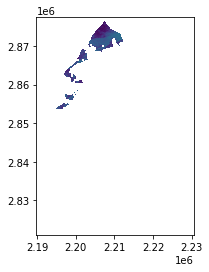

8080000062


/projects/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Zone 8080000062 clip of AGB_tindex.vrt
Writing clipped subset to /projects/my-public-bucket/test_output/analyze_agb/AGB_tindex_hybas_lev08_8080000062.tif


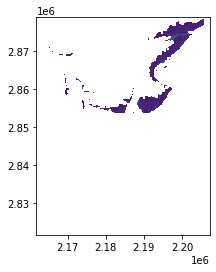

8089051211
Cant get geodataframe for feature 8089051211
# features that produced clips: 2
# features that failed to produce geodataframes: 3
# features that didnt have intersection with raster: 0


In [69]:
do_clip(r_fn, vector_gdf.head(), zone_field_name, indir, outdir, vector_file_name, SHOW_CLIP = True)